In [23]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torchvision import models

from datasets import ImagenetDataset
from fooling_model import VGG16FoolingModel, VGG19FoolingModel, ResNet50FoolingModel
from utils import for_imagenet, power_method, process_image

In [2]:
np.random.seed(2)
torch.manual_seed(2)
torch.backends.cudnn.deterministic = True

In [3]:
def calculate_fooling_rate(model, layer_id, train_batch, val_data, p=np.inf, q=10.0):
    matvec, matvec_T = model.get_matvecs(train_batch, layer_id)
    perturb, _ = power_method(init, matvec, matvec_T, p=p, q=q, max_iter=20)
    normed_perturb = perturb.view(3, 224, 224) / torch.norm(perturb, p) * MAX_PERTURB_NORM
    
    count_same = 0
    count_diff = 0
    inference_bs = 128
    for i in range(len(val_data) // inference_bs):
        val_batch = val_data[i * inference_bs: (i + 1) * inference_bs]
        with torch.no_grad():
            orig_output = model.full_forward(for_imagenet(val_batch))
            perturb_output = model.full_forward(for_imagenet(val_batch + normed_perturb))
        _, orig_preds = torch.softmax(orig_output, 1).max(1)
        _, perturb_preds = torch.softmax(perturb_output, 1).max(1)
        
        count_same += (perturb_preds == orig_preds).sum().item()
        count_diff += (perturb_preds != orig_preds).sum().item()

    print(count_diff, count_same)
    return float(count_diff) / (count_diff + count_same), normed_perturb.cpu()


In [4]:
MAX_PERTURB_NORM = 10
p = np.inf
q = 10.0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

imgs_dir = 'imgs'
imgs_paths = [os.path.join(imgs_dir, img_name) for img_name in os.listdir(imgs_dir)]

init = torch.rand(3 * 224 * 224, device=device) - 0.5

In [ ]:
fooling_model = VGG19FoolingModel(models.vgg19(pretrained=True)).to(device)
fooling_model.eval();

In [ ]:
bs_pool = list(range(5, 101, 5))
fooling_rates = []
perturbations = []

for bs in bs_pool:
    train_paths = np.random.choice(imgs_paths, size=bs, replace=False)
    val_paths = list(set(imgs_paths) - set(train_paths))
    train_dataset = ImagenetDataset(train_paths, device)
    val_dataset = ImagenetDataset(val_paths, device)
    fooling_rate, petrurbation = calculate_fooling_rate(
        model=fooling_model,
        layer_id=fooling_model.LAYERS_IDS['block2_pool'],
        train_batch=train_dataset[:],
        val_data=val_dataset
    )
    fooling_rates.append(fooling_rate)
    perturbations.append(petrurbation)

23814 26106
17214 32706
26794 23126


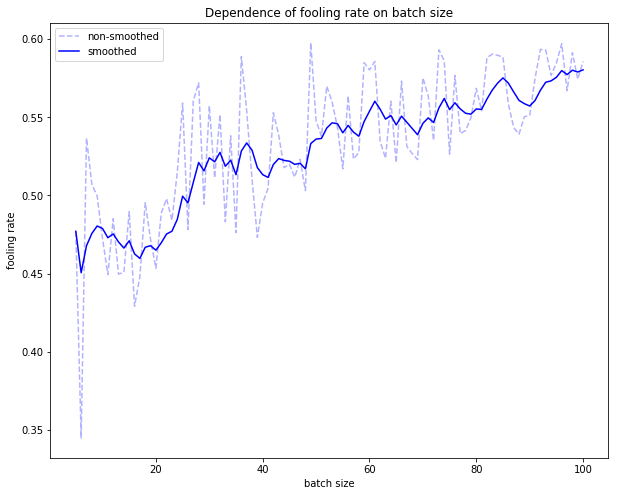

In [26]:
plt.figure(figsize=(10, 8))
plt.title('Dependence of fooling rate on batch size')
plt.xlabel('batch size')
plt.ylabel('fooling rate')
plt.plot(bs_pool, fooling_rates, 'b--', alpha=0.3, label='non-smoothed')
smoothed = list(itertools.accumulate(fooling_rates,lambda x,y : x * 0.8 + y * 0.2))
plt.plot(bs_pool, smoothed, 'b', label='smoothed')
plt.legend()